# Paper Plots, Tables, Stats

## Sample Description

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use("opinionated_rc")

df = pd.read_parquet(
    "aligning_credit/data/files/matched-repo-contributors-to-paper-members.parquet"
)
df = df.astype({"publish_date": "datetime64[ns]"})

# Get dataframe of first row of each DOI group
df_doi_first = df.groupby("doi").first().reset_index()

print("N Unique Works (Papers and Repo Pairs):", len(df_doi_first))

N Unique Works (Papers and Repo Pairs): 310


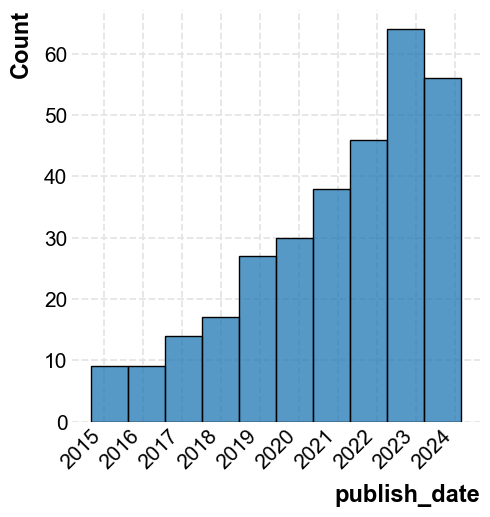

In [2]:
sns.displot(df_doi_first, x="publish_date")
_ = plt.xticks(rotation=45, ha="right")

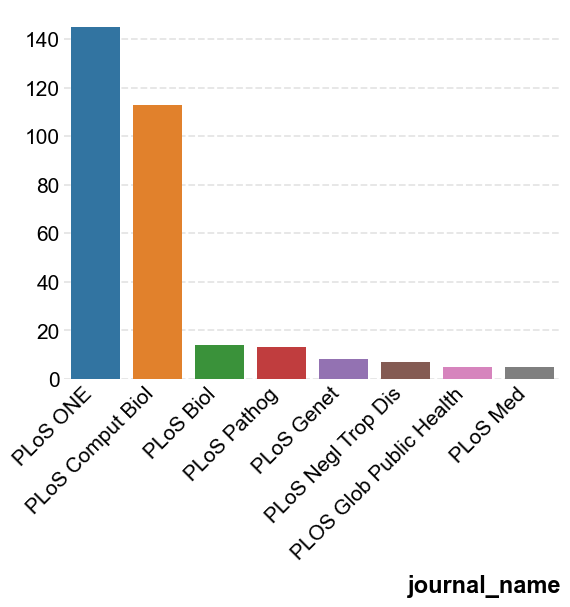

In [3]:
journal_counts = df_doi_first.journal_name.value_counts().sort_values(ascending=False)
sns.barplot(x=journal_counts.index, y=journal_counts.values, hue=journal_counts.index)
_ = plt.xticks(rotation=45, ha="right")

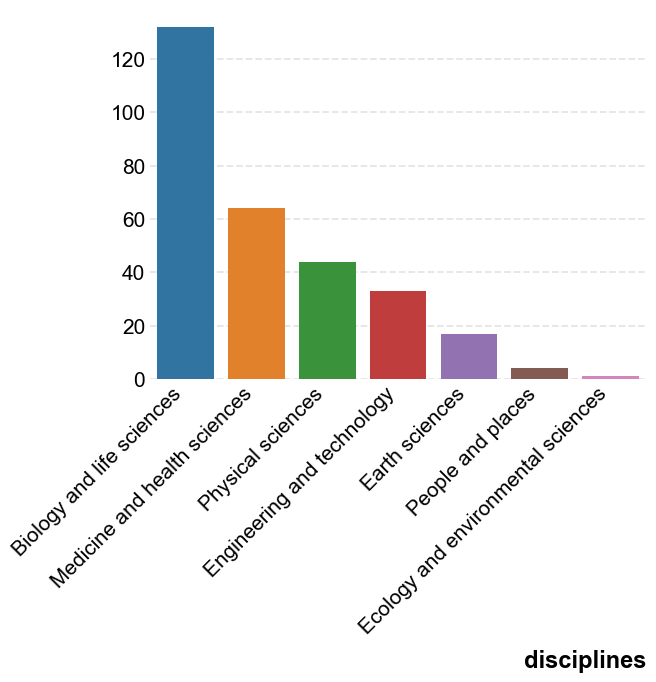

In [4]:
# Get the top level discipline for each DOI
discipline_counts = (
    df_doi_first.disciplines.apply(
        lambda x: x.split(";")[0] if isinstance(x, str) else None
    )
    .value_counts()
    .sort_values(ascending=False)
)
sns.barplot(
    x=discipline_counts.index, y=discipline_counts.values, hue=discipline_counts.index
)
_ = plt.xticks(rotation=45, ha="right")

## Authorship and Development

count                                     \
                                 count      mean       std  min  25%  50%   
known_member_dev_classification                                             
Developer                         93.0  3.462366  6.002824  1.0  1.0  1.0   
Known Member                     308.0  6.957792  5.351627  1.0  3.0  6.0   
Known Member and Developer       273.0  1.410256  0.840280  1.0  1.0  1.0   

                                            
                                 75%   max  
known_member_dev_classification             
Developer                        2.0  30.0  
Known Member                     9.0  42.0  
Known Member and Developer       2.0   8.0

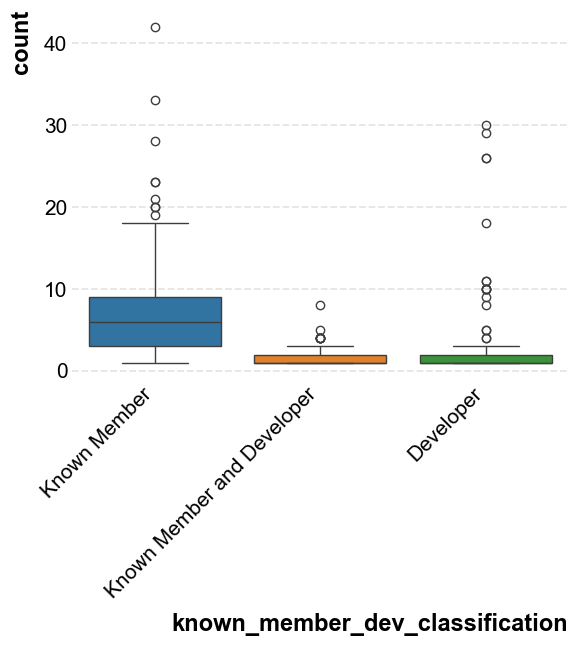

In [5]:
# Get a dataframe with the columns "doi", "known_member_dev_classification", and "count"
df_classification_counts = (
    df.groupby(["doi", "known_member_dev_classification"])
    .size()
    .reset_index(name="count")
)

sns.boxplot(
    data=df_classification_counts,
    x="known_member_dev_classification",
    y="count",
    hue="known_member_dev_classification",
)
_ = plt.xticks(rotation=45, ha="right")

# Print describe stats (over known_member_dev_classification)
df_classification_counts.groupby("known_member_dev_classification").describe()

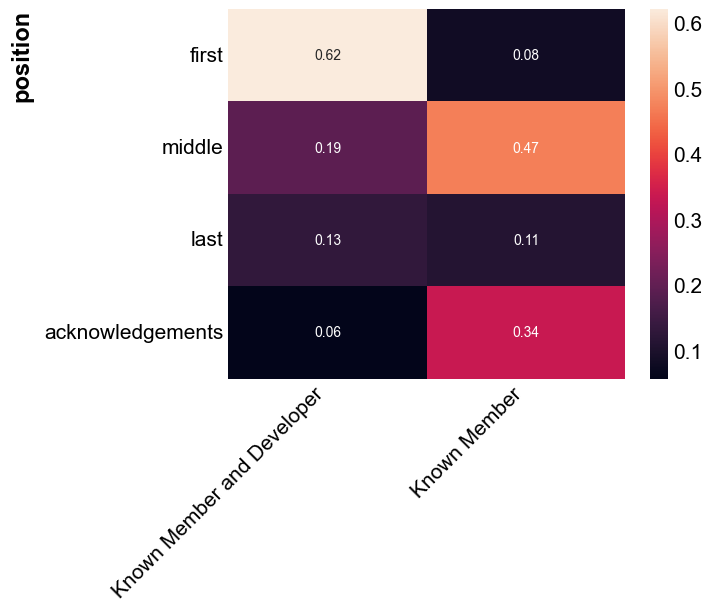

In [6]:
proportional_positions = pd.DataFrame(
    {
        "Known Member and Developer": (
            df.loc[
                df.known_member_dev_classification == "Known Member and Developer"
            ].position.value_counts()
            / len(
                df[df.known_member_dev_classification == "Known Member and Developer"]
            )
        ),
        "Known Member": (
            df.loc[
                df.known_member_dev_classification == "Known Member"
            ].position.value_counts()
            / len(df[df.known_member_dev_classification == "Known Member"])
        ),
    }
).sort_values(by="Known Member and Developer", ascending=False)

sns.heatmap(proportional_positions, annot=True, fmt=".2f")
_ = plt.xticks(rotation=45, ha="right")

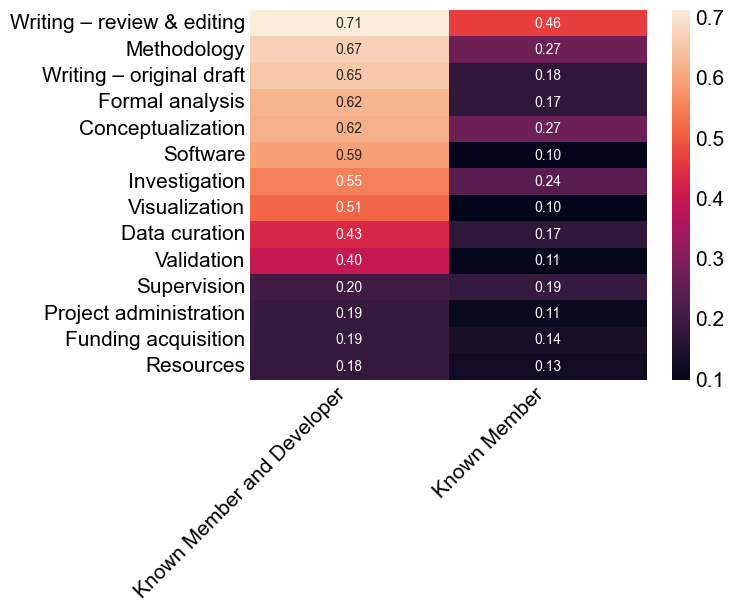

In [7]:
proportional_roles = pd.DataFrame(
    {
        "Known Member and Developer": (
            df.loc[df.known_member_dev_classification == "Known Member and Developer"]
            .roles.str.get_dummies(";")
            .sum()
            / len(
                df[df.known_member_dev_classification == "Known Member and Developer"]
            )
        ),
        "Known Member": (
            df.loc[df.known_member_dev_classification == "Known Member"]
            .roles.str.get_dummies(";")
            .sum()
            / len(df[df.known_member_dev_classification == "Known Member"])
        ),
    }
).sort_values(by="Known Member and Developer", ascending=False)

sns.heatmap(proportional_roles, annot=True, fmt=".2f")
_ = plt.xticks(rotation=45, ha="right")

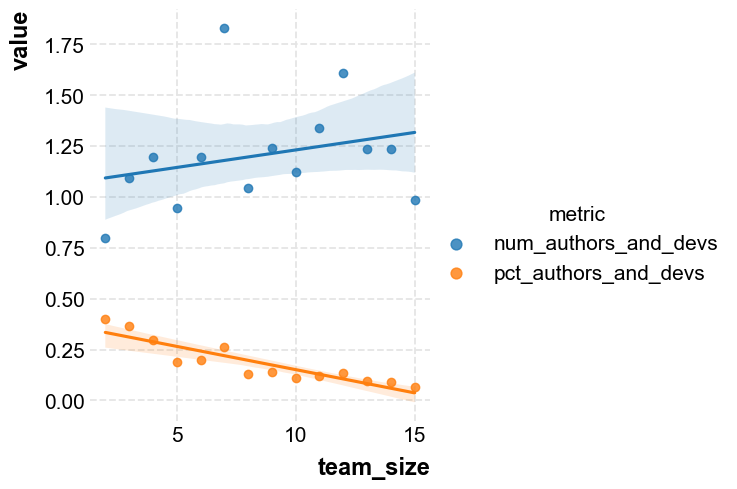

In [8]:
# Create a scatterplot with
# "Team Size ('Authors' and 'Authors and Devs')" on the x axis
# and "Number of 'Authors and Devs'" on the y axis
# Both will have to be calculated using a groupby on DOI
# and then subset to the correct author_dev_classification
# and then counted
df["team_size"] = df.groupby("doi").known_member_dev_classification.transform(
    lambda x: (x.isin(["Known Member", "Known Member and Developer"])).sum()
)
df["num_authors_and_devs"] = df.groupby(
    "doi"
).known_member_dev_classification.transform(
    lambda x: (x == "Known Member and Developer").sum()
)
df["pct_authors_and_devs"] = df["num_authors_and_devs"] / df["team_size"]

filtered_team_size = df.loc[df.team_size <= 15]

# Take the mean of pct_authors_and_devs for each team size
team_size_mean = (
    filtered_team_size.groupby("team_size")
    .agg(
        {
            "num_authors_and_devs": "mean",
            "pct_authors_and_devs": "mean",
        }
    )
    .reset_index()
)

# Melt to make it long form
team_size_melt = team_size_mean.melt(
    id_vars="team_size",
    value_vars=["num_authors_and_devs", "pct_authors_and_devs"],
    var_name="metric",
    value_name="value",
)

# Plot scatter
sns.lmplot(data=team_size_melt, x="team_size", y="value", hue="metric")